In [32]:
# !pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn fredapi openpyxl

In [294]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
from fredapi import Fred

fred = Fred(api_key='39fa3bd07f8f55540a93e075a5f97cc1')


In [295]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [305]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
# FEATURE_COLUMNS = ["close", "volume", "open", "high", "low","ema100"]
FEATURE_COLUMNS = ["close", "volume", "open", "high"
    , "low","ma7","ma21","ma100","ma50","26ema","12ema","MACD","ema","momentum"
    ,"SP500"
                   ]

# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters

N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 700

# Amazon stock market
ticker = "^GSPC"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [309]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    dataset['ma100'] = dataset['close'].rolling(window=100).mean()
    dataset['ma50'] = dataset['close'].rolling(window=50).mean()

    # Create MACD
	# candles['ema20'] = pd.Series.ewm(candles['<CLOSE>'], span=20).mean()
    dataset['26ema'] = pd.Series.ewm(dataset['close'], span=26).mean()
    dataset['12ema'] = pd.Series.ewm(dataset['close'], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    # dataset['20sd'] = pd.stats.moments.rolling_std(dataset['GS'],20)
    # dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    # dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['close']-1

    return dataset

def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['close', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        # df = si.get_data(ticker)
        df = si.get_data(ticker,'2000-01-01')
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    df = get_fred(df,"SP500")
    df = get_technical_indicators(df)

    df.replace('', np.nan, inplace=True)
    # df[feature_columns].replace('', np.nan, inplace=True)
    # df.dropna(subset=[feature_columns], inplace=True)
    # df = df.dropna()


    # print(df.tail)
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)

    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

def get_fred(dataset , ticker_fred):
    # ticker_fred = 'SP500'
    dataset_fred = fred.get_series(ticker_fred, observation_start="1/1/2000")
    dataset_fred = pd.DataFrame({'date':dataset_fred.index.tolist(),ticker_fred:dataset_fred.tolist()})
    dataset_fred.set_index('date', inplace=True)

    dataset = pd.concat([dataset, dataset_fred],axis=1)

    return dataset

In [200]:
# data_s = []
# data_s = pd.DataFrame
# data_s = get_fred('SP500')

In [205]:
# data_s.to_excel("test.xlsx")
# data_s.to_excel("test.xlsx")

In [310]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [308]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
# data["df"].to_csv(ticker_data_filename + ".csv")
# data["df"].to_excel(ticker_data_filename + ".xlsx")
# data.to_csv(ticker_data_filename + "_2.csv")

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

AssertionError: 'ma7' does not exist in the dataframe.

In [267]:
data["df"] = data["df"].dropna()

In [300]:
data["df"]

,open,high,low,close,adjclose,volume,ticker,SP500
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,9.318000e+08,^GSPC,NaN
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1.009000e+09,^GSPC,NaN
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1.085500e+09,^GSPC,NaN
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1.092300e+09,^GSPC,NaN
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1.225200e+09,^GSPC,NaN
...,...,...,...,...,...,...,...,...
2021-11-19,4708.439941,4717.750000,4694.220215,4697.959961,4697.959961,3.265600e+09,^GSPC,4697.96
2021-11-22,4712.000000,4743.830078,4682.169922,4682.939941,4682.939941,3.206280e+09,^GSPC,4682.94
2021-11-23,4678.479980,4699.390137,4652.660156,4690.700195,4690.700195,3.428780e+09,^GSPC,4690.70
2021-11-24,4675.779785,4702.870117,4659.890137,4701.459961,4701.459961,2.464040e+09,^GSPC,4701.46


In [301]:
data["df"].to_excel(ticker_data_filename + ".xlsx")

In [48]:
if os.path.exists(os.path.join("results", model_name + ".h5")):
	print("Модель уже просчитана, загружаем модель")
	# model = keras.models.load_model(path_best_model)

else:
    # some tensorflow callbacks
    checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    # train the model and save the weights whenever we see
    # a new optimal model using ModelCheckpoint
    history = model.fit(data["X_train"], data["y_train"],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(data["X_test"], data["y_test"]),
                        callbacks=[checkpointer, tensorboard],
                        verbose=1)

Модель уже просчитана, загружаем модель


In [49]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [50]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"],
                                    final_df[f"close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"],
                                    final_df[f"close_{LOOKUP_STEP}"],
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [51]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [52]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [53]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [54]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [55]:
# predict the future price
future_price = predict(model, data)

In [76]:
future_price

4547.6333

In [56]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [57]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 4547.63$
huber_loss loss: 4.081012593815103e-05
Mean Absolute Error: 87.39984067149595
Accuracy score: 0.566859344894027
Total buy profit: 13330.071949005125
Total sell profit: 4565.201774597172
Total profit: 17895.273723602295
Profit per trade: 6.896059238382387


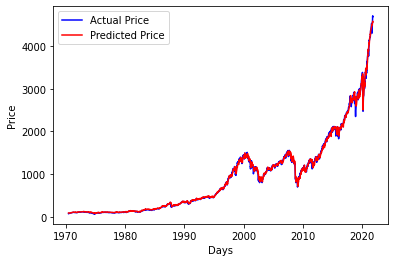

In [58]:
# plot true/pred prices graph
plot_graph(final_df)

In [59]:
final_df.head(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
1970-06-10,0.0,76.620003,74.919998,75.480003,75.480003,7240000,^GSPC,86.078293,72.940002,-2.540001,0.0
1970-06-11,0.0,75.519997,73.959999,74.449997,74.449997,7770000,^GSPC,84.551460,72.919998,-1.529999,0.0
1970-06-12,0.0,74.839996,73.250000,73.879997,73.879997,8890000,^GSPC,84.633713,71.779999,-2.099998,0.0
1970-06-19,0.0,78.050003,76.309998,77.050003,77.050003,10980000,^GSPC,84.710632,74.550003,-2.500000,0.0
1970-06-22,0.0,77.430000,75.610001,76.639999,76.639999,8700000,^GSPC,86.518181,74.419998,-2.220001,0.0
1970-06-25,0.0,74.930000,73.300003,74.019997,74.019997,8200000,^GSPC,85.628311,77.690002,3.670006,0.0
1970-07-10,0.0,75.209999,73.489998,74.449997,74.449997,10160000,^GSPC,84.702957,78.050003,3.600006,0.0
1970-07-13,0.0,75.370003,73.830002,74.550003,74.550003,7450000,^GSPC,83.074440,77.019997,2.469994,0.0
1970-07-15,0.0,75.680000,74.059998,75.230003,75.230003,8860000,^GSPC,85.324982,77.180000,1.949997,0.0
1970-08-10,0.0,77.400002,75.720001,76.199997,76.199997,7580000,^GSPC,86.515343,81.519997,5.320000,0.0


In [77]:
final_df.tail(20)

,open,high,low,close,adjclose,volume,ticker,predict,test,buy_profit,sell_profit
2021-07-06,4356.459961,4356.459961,4314.370117,4343.540039,4343.540039,3437900000,^GSPC,4384.674316,4401.459961,57.919922,0.000000
2021-07-13,4381.069824,4392.370117,4366.919922,4369.209961,4369.209961,3166900000,^GSPC,4403.547852,4423.149902,53.939941,0.000000
2021-08-06,4429.069824,4440.819824,4429.069824,4436.520020,4436.520020,2839970000,^GSPC,4441.777344,4509.370117,72.850098,0.000000
2021-08-11,4442.180176,4449.439941,4436.419922,4442.410156,4442.410156,2803060000,^GSPC,4440.674316,4524.089844,0.000000,-81.679688
2021-08-13,4464.839844,4468.370117,4460.819824,4468.000000,4468.000000,2371630000,^GSPC,4453.121094,4535.430176,0.000000,-67.430176
2021-09-02,4534.479980,4545.850098,4524.660156,4536.950195,4536.950195,2897010000,^GSPC,4512.387207,4455.479980,0.000000,81.470215
2021-09-09,4513.020020,4529.899902,4492.069824,4493.279785,4493.279785,3035300000,^GSPC,4507.974121,4307.540039,-185.739746,0.000000
2021-09-14,4479.330078,4485.680176,4435.459961,4443.049805,4443.049805,2568730000,^GSPC,4505.313965,4345.720215,-97.329590,0.000000
2021-09-15,4447.490234,4486.870117,4438.370117,4480.700195,4480.700195,3154760000,^GSPC,4502.514160,4363.549805,-117.150391,0.000000
2021-09-16,4477.089844,4485.870117,4443.799805,4473.750000,4473.750000,3321030000,^GSPC,4506.933594,4399.759766,-73.990234,0.000000


In [61]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

In [63]:
candles = final_df
import datetime

In [107]:
# Рисует основной график
def draw_candles(candles):
    # Добавим на график несколько ЕМА-средних
    # candles['ema100'] = pd.Series.ewm(candles['close'], span=100).mean()
    # candles['ema50'] = pd.Series.ewm(candles['close'], span=50).mean()
    # candles['ema20'] = pd.Series.ewm(candles['close'], span=20).mean()
    # candles['26ema'] = pd.Series.ewm(candles['close'], span=26).mean()
    # candles['12ema'] = pd.Series.ewm(candles['close'], span=12).mean()
    # candles['MACD'] = (candles['12ema']-candles['26ema'])
    plt.style.use('ggplot')  # 'seaborn-paper'
    # Отображаем график по цене закрытия свечей и ЕМА-шки
    fig = candles.plot(y=['test', 'predict','ema100','ema50','26ema','MACD','12ema'], figsize=(25, 16))
    # Добавляем заголовок
    fig.set_title('График ' + ticker)
    # Рисуем шкалу с датами
    PlotDatesX(fig, candles)

# Определяет начальную и конечную позицию Х (по индексу свечей) для заданной даты. Пригодится при отрисовке ценовых уровней
def DateX(date, candles):
    # Цикл по датам в свечах, результат - список X-координат, соответствующих заданной дате
    xpositions = [index for index, row in candles.iterrows() if row['Date'].date() == date]
    # Возвращает список - пару начальная координата Х и конечная координата Х для заданной даты на графике
    if xpositions == []:
        return [len(candles) - 1, len(candles)]  # На случай если за текущую дату нет еще свечей
    return [xpositions[0], xpositions[-1]]


# Рисует метки дат на оси Х
def PlotDatesX(fig, candles):
    # Составляем список дат (только уникальные даты) из столбца DT. Они будут метками на оси Х. Сортировка по датам
    # обязательна, т.к. при создании множества(set) даже из отсортированного списка, множество может не сохранить порядок списка
    dates = sorted(set(map(lambda dt: datetime.date(dt), candles['Date'])))
    # Создаем список координат Х для каждой метки (даты). Нам нужна только первая позиция - [0].
    xlabel = [DateX(d, candles)[0] for d in dates]
    # Рисуем ось Х, разделенную по датам
    fig.set_xticklabels(dates)
    fig.set_xticks(xlabel)
    return dates, xlabel

In [105]:
candles.rename(columns={'close_15':'predict','true_close_15':'test'}, inplace=True)
candles['Date'] = candles.index
candles['ema100'] = pd.Series.ewm(candles['close'], span=100).mean()
candles['ema50'] = pd.Series.ewm(candles['close'], span=50).mean()
candles['ema20'] = pd.Series.ewm(candles['close'], span=20).mean()
candles['26ema'] = pd.Series.ewm(candles['close'], span=26).mean()
candles['12ema'] = pd.Series.ewm(candles['close'], span=12).mean()
candles['MACD'] = (candles['12ema']-candles['26ema'])
# candles['Date']= datetime.datetime.strptime(str(candles['Date']), '%Y-%m-%d').date()#pd.to_datetime(candles['Date'],format='%Y%m%d')
candles.tail(20)

,open,high,low,close,adjclose,volume,ticker,predict,test,buy_profit,sell_profit,Date,ema100,ema50,ema20,26ema,12ema,MACD
2021-07-06,4356.459961,4356.459961,4314.370117,4343.540039,4343.540039,3437900000,^GSPC,4384.674316,4401.459961,57.919922,0.000000,2021-07-06,3493.152092,3792.440818,4082.288060,4014.990200,4176.665918,161.675718
2021-07-13,4381.069824,4392.370117,4366.919922,4369.209961,4369.209961,3166900000,^GSPC,4403.547852,4423.149902,53.939941,0.000000,2021-07-13,3510.499772,3815.059216,4109.613955,4041.228701,4206.288079,165.059378
2021-08-06,4429.069824,4440.819824,4429.069824,4436.520020,4436.520020,2839970000,^GSPC,4441.777344,4509.370117,72.850098,0.000000,2021-08-06,3528.836807,3839.430228,4140.747866,4070.509539,4241.708377,171.198838
2021-08-11,4442.180176,4449.439941,4436.419922,4442.410156,4442.410156,2803060000,^GSPC,4440.674316,4524.089844,0.000000,-81.679688,2021-08-11,3546.927368,3863.076500,4169.477608,4098.057733,4272.585574,174.527841
2021-08-13,4464.839844,4468.370117,4460.819824,4468.000000,4468.000000,2371630000,^GSPC,4453.121094,4535.430176,0.000000,-67.430176,2021-08-13,3565.166430,3886.798990,4197.908312,4125.460864,4302.649332,177.188468
2021-09-02,4534.479980,4545.850098,4524.660156,4536.950195,4536.950195,2897010000,^GSPC,4512.387207,4455.479980,0.000000,81.470215,2021-09-02,3584.409673,3912.295116,4230.198015,4155.941555,4338.695619,182.754063
2021-09-09,4513.020020,4529.899902,4492.069824,4493.279785,4493.279785,3035300000,^GSPC,4507.974121,4307.540039,-185.739746,0.000000,2021-09-09,3602.407101,3935.078828,4255.253422,4180.929572,4362.477798,181.548226
2021-09-14,4479.330078,4485.680176,4435.459961,4443.049805,4443.049805,2568730000,^GSPC,4505.313965,4345.720215,-97.329590,0.000000,2021-09-14,3619.053491,3954.999259,4273.138792,4200.345886,4374.873491,174.527606
2021-09-15,4447.490234,4486.870117,4438.370117,4480.700195,4480.700195,3154760000,^GSPC,4502.514160,4363.549805,-117.150391,0.000000,2021-09-15,3636.115802,3975.614982,4292.906544,4221.112872,4391.154523,170.041651
2021-09-16,4477.089844,4485.870117,4443.799805,4473.750000,4473.750000,3321030000,^GSPC,4506.933594,4399.759766,-73.990234,0.000000,2021-09-16,3652.702618,3995.149688,4310.129731,4239.826733,4403.861519,164.034786


TypeError: an integer is required (got type Timestamp)

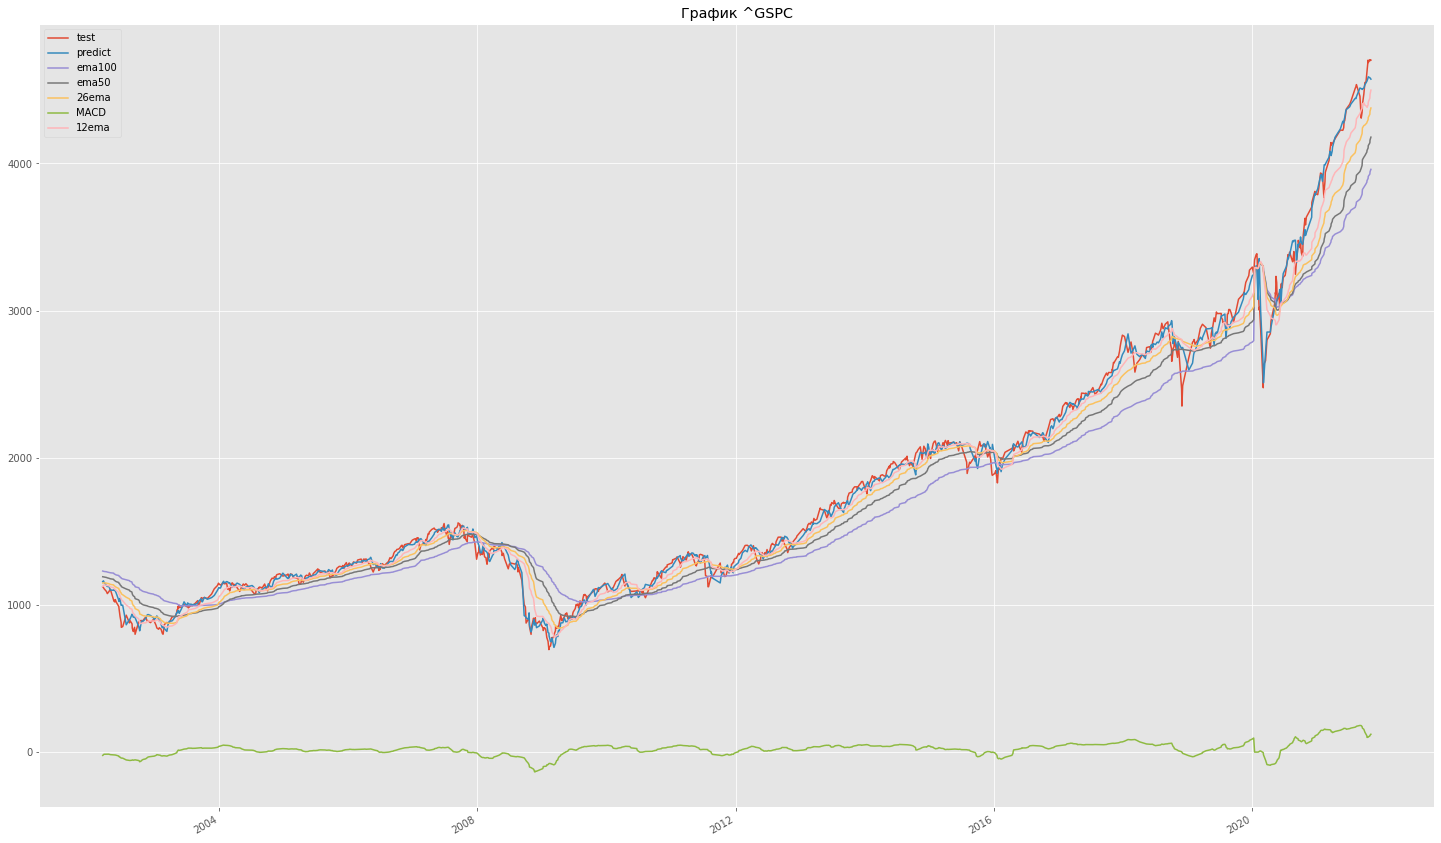

In [109]:

draw_candles(candles.tail(1000))